<a href="https://colab.research.google.com/github/SonOf1998/COVID-19_detection_in_lungs/blob/miki_workspace/COVIDDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from urllib.request import urlretrieve
import requests
import zipfile
import shutil
import random


In [2]:
url = 'https://github.com/SonOf1998/COVID-19_detection_in_lungs/archive/main.zip'
urlretrieve(url,"main.zip")

local_zip = 'main.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall()
zip_ref.close()

if os.path.exists("main.zip"):
  os.remove("main.zip")

In [3]:
if os.path.exists(os.path.join('COVID-19_detection_in_lungs-main', 'COVIDDetector.ipynb')):
  os.remove(os.path.join('COVID-19_detection_in_lungs-main', 'COVIDDetector.ipynb'))
if os.path.exists(os.path.join('COVID-19_detection_in_lungs-main', 'DocumentationPaper.docx')):
  os.remove(os.path.join('COVID-19_detection_in_lungs-main', 'DocumentationPaper.docx'))
if os.path.exists(os.path.join('COVID-19_detection_in_lungs-main', 'LICENSE')):
  os.remove(os.path.join('COVID-19_detection_in_lungs-main', 'LICENSE'))
if os.path.exists(os.path.join('COVID-19_detection_in_lungs-main', 'README.md')):
  os.remove(os.path.join('COVID-19_detection_in_lungs-main', 'README.md'))

In [4]:
destination = os.getcwd()

source = os.path.join('COVID-19_detection_in_lungs-main', 'image_datasets')
shutil.move(source, destination)

os.rmdir('COVID-19_detection_in_lungs-main')

In [5]:
for file in os.listdir('sample_data'):
  os.remove(os.path.join('sample_data', file))

os.rmdir('sample_data')

In [6]:
train_images_dir = os.path.join('image_datasets', 'train_image_dataset')
test_images_dir = os.path.join('image_datasets', 'test_image_dataset')

train_covid_images_dir = os.path.join(train_images_dir, 'covid_19')
train_no_findings_images_dir = os.path.join(train_images_dir, 'no_findings')
train_pneumonia_images_dir = os.path.join(train_images_dir, 'pneumonia')

test_covid_images_dir = os.path.join(test_images_dir, 'covid_19')
test_no_findings_images_dir = os.path.join(test_images_dir, 'no_findings')
test_pneumonia_images_dir = os.path.join(test_images_dir, 'pneumonia')

print('train images: {}'.format(len(os.listdir(train_covid_images_dir))+len(os.listdir(train_no_findings_images_dir))+len(os.listdir(train_pneumonia_images_dir))))
print('train covid images: {}'.format(len(os.listdir(train_covid_images_dir))))
print('train no findings images: {}'.format(len(os.listdir(train_no_findings_images_dir))))
print('train pneumonia images: {}'.format(len(os.listdir(train_pneumonia_images_dir))))

print('test images: {}'.format(len(os.listdir(test_covid_images_dir))+len(os.listdir(test_no_findings_images_dir))+len(os.listdir(test_pneumonia_images_dir))))
print('test covid images: {}'.format(len(os.listdir(test_covid_images_dir))))
print('test no findings images: {}'.format(len(os.listdir(test_no_findings_images_dir))))
print('test pneumonia images: {}'.format(len(os.listdir(test_pneumonia_images_dir))))

train images: 1305
train covid images: 405
train no findings images: 450
train pneumonia images: 450
test images: 145
test covid images: 45
test no findings images: 50
test pneumonia images: 50


In [7]:
from imutils import paths
import numpy as np
import argparse
import cv2
import os
from google.colab.patches import cv2_imshow

In [8]:
def dhash(image, hashSize=8):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  resized = cv2.resize(gray, (hashSize + 1, hashSize))

  diff = resized[:, 1:] > resized[:, :-1]

  return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

In [9]:
print('[INFO] computing image hashes...')
imagePaths1 = list(paths.list_images(train_covid_images_dir))
imagePaths2 = list(paths.list_images(train_no_findings_images_dir))
imagePaths3 = list(paths.list_images(train_pneumonia_images_dir))
imagePaths4 = list(paths.list_images(test_covid_images_dir))
imagePaths5 = list(paths.list_images(test_no_findings_images_dir))
imagePaths6 = list(paths.list_images(test_pneumonia_images_dir))
imagePaths = imagePaths1 + imagePaths2 + imagePaths3 + imagePaths4 + imagePaths5 + imagePaths6
hashes = {}

for imagePath in imagePaths:
  image = cv2.imread(imagePath)
  h = dhash(image)
  
  p = hashes.get(h, [])
  p.append(imagePath)
  hashes[h] = p

print('[INFO] computed image hashes.')

[INFO] computing image hashes...
[INFO] computed image hashes.


[INFO] hash: 1845524274816395954


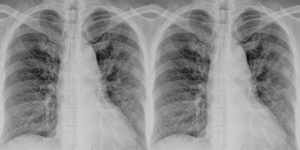

deleted: image_datasets/train_image_dataset/covid_19/covid_0010.jpg
[INFO] hash: 7758167844458351701


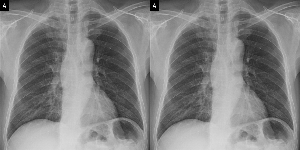

deleted: image_datasets/test_image_dataset/covid_19/covid_0446.jpeg
[INFO] hash: 1012054610167065039


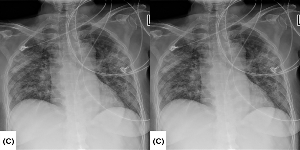

deleted: image_datasets/train_image_dataset/covid_19/covid_0060.jpg
[INFO] hash: 1085100657107103244


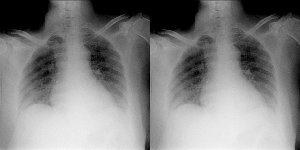

deleted: image_datasets/train_image_dataset/covid_19/covid_0097.jpg
[INFO] hash: 1085102585562352268


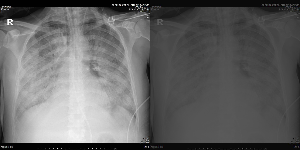

deleted: image_datasets/train_image_dataset/covid_19/covid_0064.jpg
[INFO] hash: 3147079959282502939


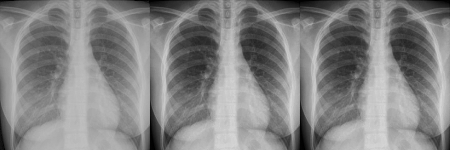

deleted: image_datasets/train_image_dataset/covid_19/covid_0222.jpg
deleted: image_datasets/train_image_dataset/covid_19/covid_0089.jpg
[INFO] hash: 3101727577994718231


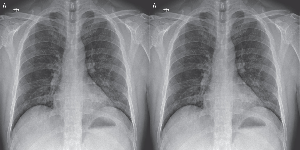

deleted: image_datasets/train_image_dataset/covid_19/covid_0104.jpeg
[INFO] hash: 1989074312909082070


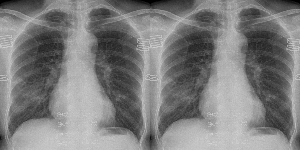

deleted: image_datasets/train_image_dataset/covid_19/covid_0138.jpeg
[INFO] hash: 544245397897227566


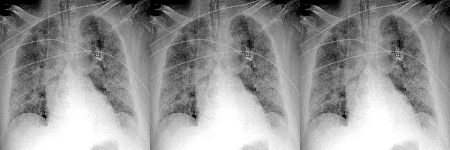

deleted: image_datasets/train_image_dataset/covid_19/covid_0185.jpg
deleted: image_datasets/train_image_dataset/covid_19/covid_0126.jpg
[INFO] hash: 1119580793615182871


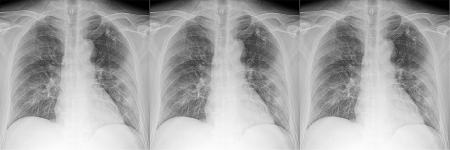

deleted: image_datasets/train_image_dataset/covid_19/covid_0157.jpg
deleted: image_datasets/test_image_dataset/covid_19/covid_0122.jpg
[INFO] hash: 1094140566327536808


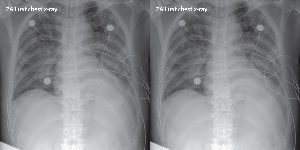

deleted: image_datasets/train_image_dataset/covid_19/covid_0092.jpg
[INFO] hash: 795947792176278604


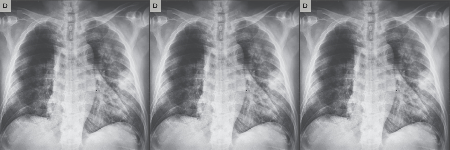

deleted: image_datasets/train_image_dataset/covid_19/covid_0140.jpeg
deleted: image_datasets/train_image_dataset/covid_19/covid_0077.jpeg
[INFO] hash: 795744657543580906


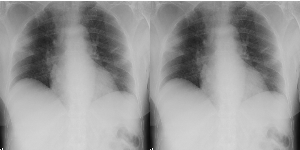

deleted: image_datasets/train_image_dataset/covid_19/covid_0121.jpeg
[INFO] hash: 966880403952060956


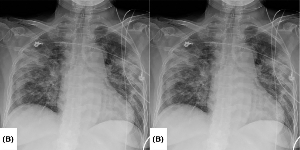

deleted: image_datasets/train_image_dataset/covid_19/covid_0059.jpg
[INFO] hash: 3434782843592100119


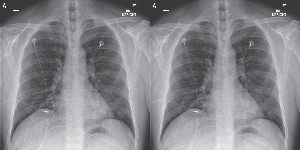

deleted: image_datasets/train_image_dataset/covid_19/covid_0100.jpeg
[INFO] hash: 9226586236924996224


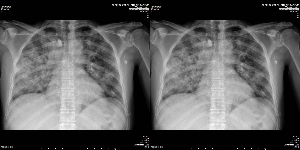

deleted: image_datasets/train_image_dataset/covid_19/covid_0156.jpeg
[INFO] hash: 10019256332374822346


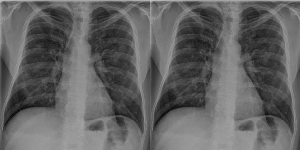

deleted: image_datasets/train_image_dataset/covid_19/covid_0209.jpeg
[INFO] hash: 2997881803056729421


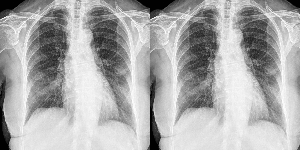

deleted: image_datasets/train_image_dataset/covid_19/covid_0186.png
[INFO] hash: 3390941258473626460


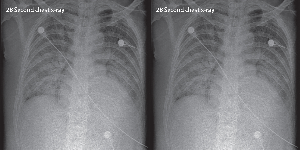

deleted: image_datasets/train_image_dataset/covid_19/covid_0224.jpg
[INFO] hash: 1012762420823419750


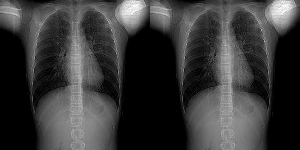

deleted: image_datasets/test_image_dataset/covid_19/covid_0132.png
[INFO] hash: 1085100661351852875


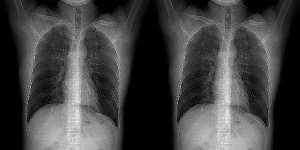

deleted: image_datasets/train_image_dataset/covid_19/covid_0112.png
[INFO] hash: 1085102851277663181


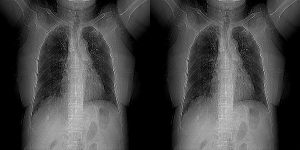

deleted: image_datasets/train_image_dataset/covid_19/covid_0082.png
[INFO] hash: 2561016621096102989


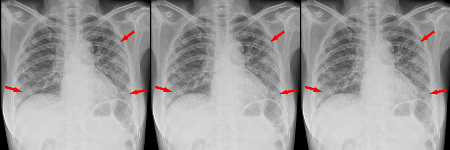

deleted: image_datasets/train_image_dataset/covid_19/covid_0106.jpeg
deleted: image_datasets/train_image_dataset/covid_19/covid_0443.jpeg
[INFO] hash: 5731829766240684035


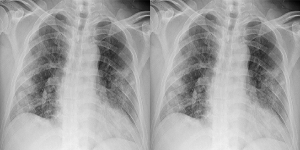

deleted: image_datasets/train_image_dataset/covid_19/covid_0154.jpg
[INFO] hash: 1093125169461611996


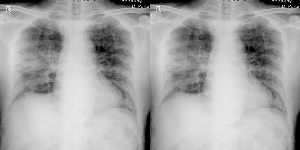

deleted: image_datasets/train_image_dataset/covid_19/covid_0146.jpeg
[INFO] hash: 2387835017436436756


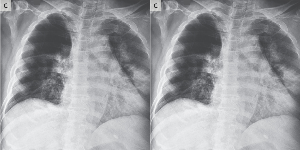

deleted: image_datasets/train_image_dataset/covid_19/covid_0143.jpeg
[INFO] hash: 508637709486074639


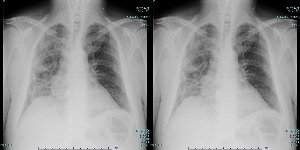

deleted: image_datasets/train_image_dataset/covid_19/covid_0085.jpeg
[INFO] hash: 1084606980142230540


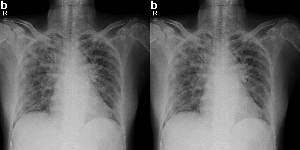

deleted: image_datasets/test_image_dataset/covid_19/covid_0124.jpg
[INFO] hash: 5713668309199898292


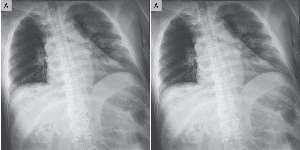

deleted: image_datasets/test_image_dataset/covid_19/covid_0110.jpeg
[INFO] hash: 1085102585034958989


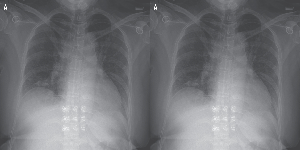

deleted: image_datasets/train_image_dataset/covid_19/covid_0094.jpeg
[INFO] hash: 1084677621625172503


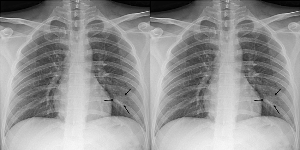

deleted: image_datasets/train_image_dataset/covid_19/covid_0160.jpg
[INFO] hash: 1388634312588945871


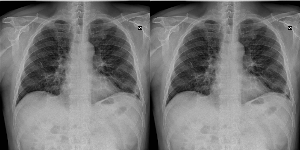

deleted: image_datasets/train_image_dataset/covid_19/covid_0057.jpeg
[INFO] hash: 4552357876217441370


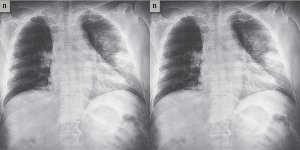

deleted: image_datasets/train_image_dataset/covid_19/covid_0075.jpeg
[INFO] hash: 1661704899453087019


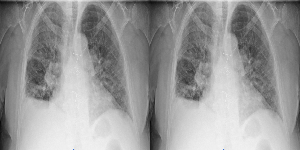

deleted: image_datasets/train_image_dataset/covid_19/covid_0123.jpeg
[INFO] hash: 832194842393848326


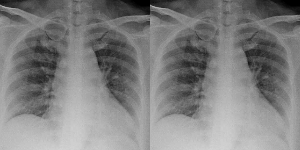

deleted: image_datasets/train_image_dataset/covid_19/covid_0011.jpg
[INFO] hash: 804929153041746983


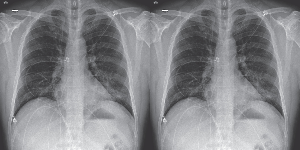

deleted: image_datasets/test_image_dataset/covid_19/covid_0230.jpeg
[INFO] hash: 552446098938809357


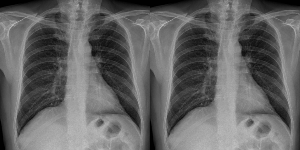

deleted: image_datasets/test_image_dataset/covid_19/covid_0049.jpeg
[INFO] hash: 10019258514218208602


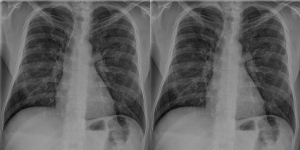

deleted: image_datasets/test_image_dataset/covid_19/covid_0207.jpeg
[INFO] hash: 1085102842641459468


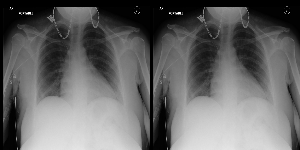

deleted: image_datasets/train_image_dataset/no_findings/no_findings_0254.png


In [10]:
for (h, hashedPaths) in hashes.items():
  if len(hashedPaths) > 1:
    montage = None
    for p in hashedPaths:
      image = cv2.imread(p)
      image = cv2.resize(image, (150, 150))
      if montage is None:
        montage = image
      else:
        montage = np.hstack([montage, image])
    print('[INFO] hash: {}'.format(h))
    cv2_imshow(montage)
    cv2.waitKey(0)
    
    for p in hashedPaths[1:]:
      os.remove(p)
      print('deleted: {}'.format(p))

In [11]:
print('train images: {}'.format(len(os.listdir(train_covid_images_dir))+len(os.listdir(train_no_findings_images_dir))+len(os.listdir(train_pneumonia_images_dir))))
print('train covid images: {}'.format(len(os.listdir(train_covid_images_dir))))
print('train no findings images: {}'.format(len(os.listdir(train_no_findings_images_dir))))
print('train pneumonia images: {}'.format(len(os.listdir(train_pneumonia_images_dir))))

print('test images: {}'.format(len(os.listdir(test_covid_images_dir))+len(os.listdir(test_no_findings_images_dir))+len(os.listdir(test_pneumonia_images_dir))))
print('test covid images: {}'.format(len(os.listdir(test_covid_images_dir))))
print('test no findings images: {}'.format(len(os.listdir(test_no_findings_images_dir))))
print('test pneumonia images: {}'.format(len(os.listdir(test_pneumonia_images_dir))))

train images: 1269
train covid images: 370
train no findings images: 449
train pneumonia images: 450
test images: 137
test covid images: 37
test no findings images: 50
test pneumonia images: 50
